In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [40]:
from utils import build_dataset

# ------------------------------------------------------------------------------
# utils ------------------------------------------------------------------

# Add a bias unit to the input
def biased(x):
    return np.hstack([1, x])

# sigmoid function
# t   float temperature
def sigmfun(x, t=1.0):
    return 1.0 / (1.0 + np.exp(-x / t))

# sigmoid derivative
def sigmder(y):
    return y * (1 - y)

# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

In [41]:
class BackProp(object):
    """
    Error back propagation algorithm for
    the learning of the weights of a multi-layered perceptron.
    """

    def __init__(self,
                 outfun=sigmfun,
                 derfun=sigmder,
                 eta=0.01,
                 n_units_per_layer=[2, 2, 1]):
        """
        :param  outfun              transfer functions for units'output
        :param  derfun              derivative of the units'output function
        :param  eta                 learning rate
        :param  n_units_per_layer   number of units per each layer
        """

        # function pointers

        # transfer functions for units'output
        self.outfun = outfun

        # derivative of the units'output function
        self.derfun = derfun

        # Constants

        # Learning rate
        self.eta = eta

        # number of layer units
        self.n_units_per_layer = n_units_per_layer

        # number of layers
        self.n_layers = len(self.n_units_per_layer)

        # Variables

        # Initialize units
        self.units = []
        for n in self.n_units_per_layer:
            self.units.append(np.zeros(n))

        # Initialize deltas
        self.deltas = []
        for n in self.n_units_per_layer:
            self.deltas.append(np.zeros(n))

        # Initialize weights
        self.weights = []
        for n_out, n_inp in zip(self.n_units_per_layer[1:],
                                self.n_units_per_layer[:-1]):
            self.weights.append(
                np.random.randn(n_out, n_inp + 1))

    def step(self, input_pattern):
        """
        :param  input_pattern  the current input pattern
        """
        # spreading

        # linear function
        self.units[0] = input_pattern.copy()

        # iterate deep layers
        for layer in xrange(self.n_layers - 1):
            # Bias-plus-input vector
            input_pattern = np.dot(self.weights[layer],
                                   biased(self.units[layer]))
            # nonlinear function
            self.units[layer + 1] = self.outfun(input_pattern)

    def error_backprop(self, target):
        """
        :param  target  the desired output for the current input
        """

        # the initial outer-error is the real one
        #     (expected vs real outputs)
        self.error = target - self.units[-1]

        self.deltas[-1] = self.error * self.derfun(self.units[-1])
        # iterate layers backward
        for layer in xrange(self.n_layers - 1, 0, -1):
            # for each layer evaluate the back-propagation error
            w_T = (self.weights[layer - 1][:, 1:]).T
            self.deltas[layer - 1] = \
                np.dot(w_T, self.deltas[layer]) * \
                self.derfun(self.units[layer - 1])

    def update_weights(self):

        for layer in xrange(self.n_layers - 1):
            # error plus derivative
            self.weights[layer] += self.eta * np.outer(
                self.deltas[layer + 1],
                biased(self.units[layer]))

    def learn(self, target):
        """
        :param  target  the desired output for the current input
        """

        self.error_backprop(target)
        self.update_weights()

    def get_mse(self):
        return np.mean(self.error**2)

In [42]:

# Create the backprop object
bp = BackProp(outfun=sigmfun,
              derfun=sigmder,
              eta=0.01,
              n_units_per_layer=[2, 200, 1])


# number of training patterns

num_training_patterns = 200

# number of learning epochs
epochs = 200


# create a data set wth two groups od two-dimensional points.
# the two groups are disposed within two circle areas. The area
# of one group is inscribed in the other
circle_set1 = []
circle_set2 = []

for a in xrange(0, 99):
    angle = a * ((np.pi * 2) / 98.0)
    circle_set1.append([2 * np.cos(angle), 2 * np.sin(angle)])
    circle_set2.append([.2 * np.cos(angle), .2 * np.sin(angle)])

# Make training data
training_data = build_dataset(num_training_patterns,
                              centroids1=np.array(circle_set1),
                              centroids2=np.array(circle_set2),
                              std_deviation=0.05)

#-------------------------------------------------------------------------
# Iput and desired output

# Each row of P is an input pattern
training_patterns = 0.5*training_data[:, :2] + 0.5

# Each element of o is the desired output
# relative to an input pattern
training_targets = training_data[:, 2]

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

# Create a list of pattern indices.
# We will reshuffle it at each
# repetition of the series
pattern_indices = np.arange(num_training_patterns)

# Create a container to store errors
errors = np.zeros(epochs)

# training loop
for epoch in xrange(epochs):

    random.shuffle(pattern_indices)
    error = np.zeros(num_training_patterns)

    for t in xrange(num_training_patterns):

        # Current pattern
        input_pattern = training_patterns[t]
        target_pattern = training_targets[t]

        # spreading and learning
        bp.step(input_pattern)
        bp.learn(target_pattern)

        # current error
        error[t] = bp.get_mse()

    errors[epoch] = error.mean()

# test loop

# define the limits of the input space
upper_bound = training_patterns.max(0) + \
    0.2 * (training_patterns.max(0) - training_patterns.min(0))
lower_bound = training_patterns.min(0) - \
    0.2 * (training_patterns.max(0) - training_patterns.min(0))

# define a test dataset made of a grid of points expanding
# through the whole input space
test_outputs = np.zeros([100, 100])

X = np.linspace(lower_bound[0], upper_bound[0], 100)
Y = np.linspace(lower_bound[1], upper_bound[1], 100)
XX, YY = np.meshgrid(X, Y)

# iterate over the two dimesnions of the space
for y, j in zip(Y, xrange(100)):
    for x, i in zip(X, xrange(100)):

        # Current pattern
        input_pattern = np.hstack([x, y])

        # spreading
        bp.step(input_pattern)

        # store output
        test_outputs[i,j] = bp.units[bp.n_layers - 1][0]

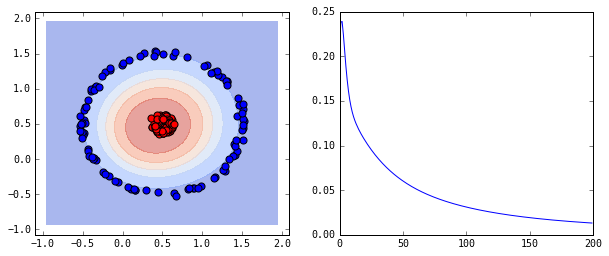

In [43]:
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(121)
    ax1.contourf(XX,YY,-test_outputs,alpha=0.5,cmap=plt.cm.coolwarm)
    ax1.scatter(*training_patterns[training_targets<=0,:].T, s=50, c="r")
    ax1.scatter(*training_patterns[training_targets>0,:].T, s=50, c="b")
    ax2 = fig.add_subplot(122)
    ax2.plot(errors)
    plt.show()
  

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
Next cell is just for styling

In [44]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../style/ipybn.css", "r").read()
    return HTML(styles)
css_styling()